# Statistical analysis to get the significantly associated annotations associated with high risk scores

## Read mapping information

In [1]:
import os

import pandas as pd


demoTrainDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_train.csv', sep='\t')
demoTestDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_test.csv', sep='\t')
demoValidateDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_validate.csv', sep='\t')
demoDf = pd.concat([demoTrainDf, demoTestDf, demoValidateDf], ignore_index=True)
demoDf

,person_id,visit_occurrence_id,TYPE,COUNTRY_OF_BIRTH,SEX,Age_Bin,JOURNEY_ID
0,678487,3312694,Emergency,Australia,Male,"(60, 70]",3312694
1,2094045,9199249,Emergency,Australia,Male,"(20, 30]",9199249
2,2107813,9410987,Emergency,Australia,Male,"(50, 60]",9410987
3,2083212,602890,Inpatient,Australia,Female,"(40, 50]",9039437
4,2083212,9039437,Emergency,Australia,Female,"(40, 50]",9039437
...,...,...,...,...,...,...,...
7194,2603535,16588204,Inpatient,Australia,Male,"(60, 70]",16588204
7195,2603535,16709341,Inpatient,Australia,Male,"(60, 70]",16709341
7196,2603535,16651755,Inpatient,Australia,Male,"(60, 70]",16651755
7197,2098616,16872774,Emergency,Australia,Female,"(80, 90]",16872774


In [2]:
import os

mappingDf = pd.read_csv(os.environ['GENOMICS_DATA_BASE'] + '/patient_tube_id_mapping_full.tsv', sep='\t')
mappingDf

,tube_code,PATIENT_ID,db_ID,pt_age,pt_gender,EPISODE_ID,hospital_admission,hospital_discharge,hospital_in_last_year,genome_species,species_reported,contig_number,length,tube_code_duplicate_or_old,date_of_collection,ID_number,location_additional_02,collected_from_original
0,AH19J072,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Escherichia coli,Escherichia coli,92,5131021,NaN,2019-10-30,19-303-0997,A-7EA;HAEM,Blood
1,AH19J074,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Streptococcus sp. D19,Streptococcus mitis group,84,2022991,NaN,2019-10-30,19-303-1174,A-7EA;HAEM,Blood Peripheral
2,AH19B003,526238.0,567AE,85,Male,640261.0,2019-02-04,2019-02-07,no,Escherichia coli,Escherichia coli,93,4942915,NaN,2019-02-03,19-034-1596,A-4WB;GMC,Blood
3,AH20A024,788941.0,3YBDS,58,Female,13194824.0,2020-01-16,2020-01-19,no,Escherichia coli,Escherichia coli,110,5149157,NaN,2020-01-16,20-016-2112,S-ED;Emergency,Blood Venous
4,AH20L041,1023735.0,2VJ78,42,Male,14210147.0,2020-12-18,2021-01-05,yes,Staphylococcus aureus,Staphylococcus aureus,46,2735216,NaN,2020-12-16,20-351-2856,Emergency Dept;nan,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,ALF22L076,639020.0,3S6HL,84,Male,17219899.0,2022-12-15,2022-12-20,yes,Streptococcus vestibularis,Streptococcus salivarius group,107,1938627,NaN,2022-12-15,22-349-2150,Ward 4WB,Blood Peripheral
3113,ALF22L089,655404.0,6EWBM,67,Female,NaN,NaN,NaN,NaN,Proteus columbae,Proteus vulgaris,152,3972219,NaN,2022-12-17,22-351-1465,Comm/Amb Clinic,Blood
3114,ALF22L138,2572048.0,YM5PJ,61,Male,NaN,NaN,NaN,NaN,Enterobacter roggenkampii,Enterobacter cloacae complex,66,4876179,NaN,2022-12-27,22-361-0202,Ward 7 East,Hick White Lum
3115,ALF23A102,2054964.0,5DYAH,35,Female,17294287.0,2023-01-12,2023-02-01,yes,Streptococcus constellatus,Streptococcus anginosus group,54,1869828,NaN,2023-01-11,23-011-3305,ICU,Blood Venous


In [3]:
mappedJourneyTubeIdsDf = mappingDf[['tube_code', 'PATIENT_ID', 'EPISODE_ID']].drop_duplicates().merge(
    demoDf[['person_id', 'visit_occurrence_id', 'JOURNEY_ID']],
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID', 'visit_occurrence_id']
)[['person_id', 'JOURNEY_ID', 'tube_code']].drop_duplicates()
mappedJourneyTubeIdsDf

,person_id,JOURNEY_ID,tube_code
0,50056,13224842,AH20B011
1,62567,12645629,AH19G065
2,138108,14737781,AH21E052
3,211314,13955099,AH20J009
4,211314,13955099,KPN2214
...,...,...,...
512,2084373,16158768,ALF22C004
513,1058066,16759482,ALF22H089
514,2552781,16966609,ALF22J054
515,2638484,16969999,ALF22K143


## Read risk scores

In [4]:
import os

import pandas as pd


predictionsDir = os.environ['EHR_DATA_BASE'] + '/saur_cohort_20250113/predictions'

predictionsDfList = []
for mortality in [7, 14, 30]:
    for wa in [0, 1, 2, 3]:
        predictionsFile = predictionsDir + '/wb_365_wa_' + str(wa) + '/' + str(mortality) + '_day_mortality_normal.csv'
        tempDf = pd.read_csv(predictionsFile)
        tempDf['mortality'] = mortality
        tempDf['wa'] = wa
        predictionsDfList.append(tempDf)

predictionsDf = pd.concat(predictionsDfList, ignore_index=True)
predictionsDf

,person_id,JOURNEY_ID,preds,mortality,wa
0,288310,16626198,0.030236,7,0
1,291268,15846616,0.004774,7,0
2,291268,16413770,0.006620,7,0
3,291268,17129639,0.089311,7,0
4,294182,17137564,0.000708,7,0
...,...,...,...,...,...
1459,2665827,17260382,0.012087,30,3
1460,2665827,17285820,0.736891,30,3
1461,2676010,17425701,0.000412,30,3
1462,2676371,17444357,0.011165,30,3


### Get tube ids for predictions

In [5]:
mergedDf = predictionsDf.merge(
    mappedJourneyTubeIdsDf,
    how='inner',
    on=['person_id', 'JOURNEY_ID']
)
mergedDf

,person_id,JOURNEY_ID,preds,mortality,wa,tube_code
0,1733673,16562760,0.001997,7,0,ALF22G032
1,2094453,17015298,0.001224,7,0,ALF22K018
2,2094453,17015298,0.001224,7,0,ALF22K019
3,2094453,17015298,0.001224,7,0,ALF22K021
4,2131387,17513763,0.002923,7,0,ALF23C182
...,...,...,...,...,...,...
247,2637660,17172503,0.004081,30,3,ALF22L046
248,2647426,17410677,0.003788,30,3,ALF23C128
249,2665827,17285820,0.736891,30,3,ALF23A038
250,2676371,17444357,0.011165,30,3,ALF23C055


## Read annotations

In [6]:
gff3DfList = []
for i, row in mergedDf.iterrows():
    fileName = os.environ['GENOMICS_DATA_BASE'] + '/annotations/s_aureus_gff3/' + row.tube_code + '.gff3'
    if(os.path.isfile(fileName)):
        gff3Df = pd.read_csv(
            fileName,
            comment='#',
            sep='\t',
            names=['sequence_id', 'source', 'feature_type', 'feature_start', 'feature_end', 'score', 'strand', 'phase', 'atributes']
        )
        gff3Df['id'] = gff3Df.atributes.apply(lambda x: [att.split('=')[1] for att in x.split(';') if att.split('=')[0] == 'ID']).apply(lambda x: None if (len(x) == 0) else x[0])
        gff3Df['name'] = gff3Df.atributes.apply(lambda x: [att.split('=')[1] for att in x.split(';') if att.split('=')[0] == 'Name']).apply(lambda x: None if (len(x) == 0) else x[0])
        gff3Df['gene'] = gff3Df.atributes.apply(lambda x: [att.split('=')[1] for att in x.split(';') if att.split('=')[0] == 'gene']).apply(lambda x: None if (len(x) == 0) else x[0])
        gff3Df['tube_code'] = row.tube_code
        gff3DfList.append(gff3Df)
annotationsDf = pd.concat(gff3DfList, ignore_index=True)
annotationsDf

,sequence_id,source,feature_type,feature_start,feature_end,score,strand,phase,atributes,id,name,gene,tube_code
0,1,Bakta,region,1,1088229,.,+,.,ID=1;Name=1,1,1,None,ALF22G032
1,1,Prodigal,CDS,350,1414,.,-,0,ID=ODFNLF_00005;Name=Fe-S cluster carrier ATPa...,ODFNLF_00005,Fe-S cluster carrier ATPase%2C Mrp/ApbC/NBP35 ...,mrp,ALF22G032
2,1,Prodigal,CDS,1562,3004,.,-,0,ID=ODFNLF_00010;Name=multidrug efflux MFS tran...,ODFNLF_00010,multidrug efflux MFS transporter LmrS,lmrS,ALF22G032
3,1,Prodigal,CDS,3327,3794,.,-,0,ID=ODFNLF_00015;Name=multidrug efflux transpor...,ODFNLF_00015,multidrug efflux transporter SepA,sepA,ALF22G032
4,1,Prodigal,CDS,3926,5242,.,-,0,ID=ODFNLF_00020;Name=multidrug efflux MFS tran...,ODFNLF_00020,multidrug efflux MFS transporter SdrM,sdrM,ALF22G032
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501115,32,Bakta,region,1,167,.,+,.,ID=32;Name=32,32,32,None,ALF23C124
501116,33,Bakta,region,1,163,.,+,.,ID=33;Name=33,33,33,None,ALF23C124
501117,34,Bakta,region,1,144,.,+,.,ID=34;Name=34,34,34,None,ALF23C124
501118,35,Bakta,region,1,135,.,+,.,ID=35;Name=35,35,35,None,ALF23C124


In [7]:
len(annotationsDf.tube_code.unique())

15

## Merge all the data

In [17]:
finalDf = annotationsDf.merge(
    mergedDf,
    how='inner',
    on=['tube_code']
)
finalDf = finalDf[finalDf.feature_type.isin(['CDS', 'ncRNA', 'oriC', 'regulatory_region', 'oriT'])]
finalDf

,sequence_id,source,feature_type,feature_start,feature_end,score,strand,phase,atributes,id,name,gene,tube_code,person_id,JOURNEY_ID,preds,mortality,wa
12,1,Prodigal,CDS,350,1414,.,-,0,ID=ODFNLF_00005;Name=Fe-S cluster carrier ATPa...,ODFNLF_00005,Fe-S cluster carrier ATPase%2C Mrp/ApbC/NBP35 ...,mrp,ALF22G032,1733673,16562760,0.001997,7,0
13,1,Prodigal,CDS,350,1414,.,-,0,ID=ODFNLF_00005;Name=Fe-S cluster carrier ATPa...,ODFNLF_00005,Fe-S cluster carrier ATPase%2C Mrp/ApbC/NBP35 ...,mrp,ALF22G032,1733673,16562760,0.001924,7,1
14,1,Prodigal,CDS,350,1414,.,-,0,ID=ODFNLF_00005;Name=Fe-S cluster carrier ATPa...,ODFNLF_00005,Fe-S cluster carrier ATPase%2C Mrp/ApbC/NBP35 ...,mrp,ALF22G032,1733673,16562760,0.006538,7,2
15,1,Prodigal,CDS,350,1414,.,-,0,ID=ODFNLF_00005;Name=Fe-S cluster carrier ATPa...,ODFNLF_00005,Fe-S cluster carrier ATPase%2C Mrp/ApbC/NBP35 ...,mrp,ALF22G032,1733673,16562760,0.023731,7,3
16,1,Prodigal,CDS,350,1414,.,-,0,ID=ODFNLF_00005;Name=Fe-S cluster carrier ATPa...,ODFNLF_00005,Fe-S cluster carrier ATPase%2C Mrp/ApbC/NBP35 ...,mrp,ALF22G032,1733673,16562760,0.001997,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6013243,23,Prodigal,CDS,109,1428,.,+,0,ID=MKMKCJ_13630;Name=ISL3 family IS1181 transp...,MKMKCJ_13630,ISL3 family IS1181 transposase,tnp,ALF23C124,2679272,17485225,0.582057,14,3
6013244,23,Prodigal,CDS,109,1428,.,+,0,ID=MKMKCJ_13630;Name=ISL3 family IS1181 transp...,MKMKCJ_13630,ISL3 family IS1181 transposase,tnp,ALF23C124,2679272,17485225,0.518066,30,0
6013245,23,Prodigal,CDS,109,1428,.,+,0,ID=MKMKCJ_13630;Name=ISL3 family IS1181 transp...,MKMKCJ_13630,ISL3 family IS1181 transposase,tnp,ALF23C124,2679272,17485225,0.166281,30,1
6013246,23,Prodigal,CDS,109,1428,.,+,0,ID=MKMKCJ_13630;Name=ISL3 family IS1181 transp...,MKMKCJ_13630,ISL3 family IS1181 transposase,tnp,ALF23C124,2679272,17485225,0.308345,30,2


## Counts

In [18]:
finalDf[['sequence_id', 'feature_type', 'source']].groupby(by=['feature_type', 'source']).agg('count')

sequence_id
feature_type      source               
CDS               Bakta           33264
                  Prodigal      5494896
ncRNA             Infernal       173376
oriC              BLAST+           5328
oriT              BLAST+           1584
regulatory_region Infernal        54144

## Risk score distribution

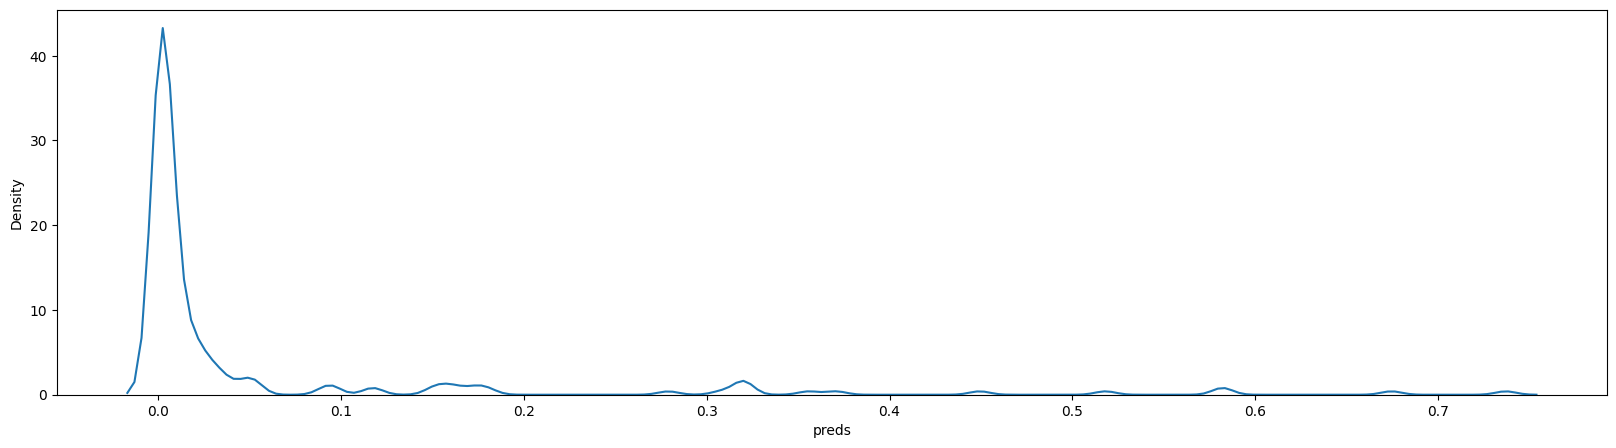

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns


plt.figure(figsize=(20,5))

sns.kdeplot(data=finalDf, x='preds')

plt.show()

### High risk score

In [20]:
cutoff = finalDf.preds.mean() + 2 * finalDf.preds.std()
cutoff

np.float64(0.3026455327135738)

## Perform chi-square test for gene names

In [34]:
from scipy import stats

highScoreOverlappingDf = finalDf[(finalDf.preds > cutoff)].gene.value_counts().reset_index()
lowScoreOverlappingDf = finalDf[(finalDf.preds < cutoff)].gene.value_counts().reset_index()
mergedOverlappingDf = highScoreOverlappingDf.add_suffix('_hs').merge(
    lowScoreOverlappingDf.add_suffix('_ls'),
    how='inner',
    left_on=['gene_hs'],
    right_on=['gene_ls']
)[['gene_hs', 'count_hs', 'count_ls']].rename(columns={'gene_hs': 'feature_type'})

mergedOverlappingDf['proportion_ls'] = mergedOverlappingDf.count_ls/mergedOverlappingDf.count_ls.sum()

mergedOverlappingDf['count_expected'] = mergedOverlappingDf.proportion_ls * mergedOverlappingDf.count_hs.sum()

filteredOverlappingDf = mergedOverlappingDf[(mergedOverlappingDf.count_hs >= 5) & (mergedOverlappingDf.count_ls >= 5)]

chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(filteredOverlappingDf.count_hs, filteredOverlappingDf.count_expected), correction=True)
significant = p < 0.05  # 5% significance level
print(chi2, p, significant)

83696.52777777778 0.0 True


### Calculate the ratio of count differences

In [35]:
filteredOverlappingDf.loc[:, 'ratio_difference'] = (filteredOverlappingDf.count_hs / filteredOverlappingDf.count_expected)

### Over represented tokens associated with the high attribution score

In [39]:
overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 3]
overrepresentedTokensDf

/tmp/ipykernel_13442/3263614894.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 3]


,feature_type,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
1749,mbpX,84,348,0.000084,27.323836,3.074239
1746,secB,84,348,0.000084,27.323836,3.074239
1725,racA,84,348,0.000084,27.323836,3.074239
1702,pgsA,96,336,0.000081,26.381635,3.638895
1750,ser,84,204,0.000049,16.017421,5.244290
1732,psbH,84,204,0.000049,16.017421,5.244290
1751,abiK,84,204,0.000049,16.017421,5.244290
1739,sej,84,204,0.000049,16.017421,5.244290
1731,comEA,84,204,0.000049,16.017421,5.244290
1745,sed,84,204,0.000049,16.017421,5.244290


### Under represented tokens associated with the high attribution score

In [41]:
underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.5]
underrepresentedTokensDf

/tmp/ipykernel_13442/3382577452.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.5]


,feature_type,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
1818,lpl6,12,852,0.000205,66.896288,0.179382
1809,refA1,12,852,0.000205,66.896288,0.179382
1813,yopX,12,708,0.000171,55.589874,0.215867
1791,pinE,24,1128,0.000272,88.566917,0.270982
1804,mecR1,12,564,0.000136,44.283459,0.270982
1795,gltR,12,420,0.000101,32.977044,0.363890
1812,rINB,12,420,0.000101,32.977044,0.363890
1803,esxC,12,420,0.000101,32.977044,0.363890
1799,tarM,12,420,0.000101,32.977044,0.363890
1810,comGF,12,420,0.000101,32.977044,0.363890


## Perform chi-square test for annotations

In [42]:
from scipy import stats

highScoreOverlappingDf = finalDf[(finalDf.preds > cutoff)].name.value_counts().reset_index()
lowScoreOverlappingDf = finalDf[(finalDf.preds < cutoff)].name.value_counts().reset_index()
mergedOverlappingDf = highScoreOverlappingDf.add_suffix('_hs').merge(
    lowScoreOverlappingDf.add_suffix('_ls'),
    how='inner',
    left_on=['name_hs'],
    right_on=['name_ls']
)[['name_hs', 'count_hs', 'count_ls']].rename(columns={'name_hs': 'feature_type'})

mergedOverlappingDf['proportion_ls'] = mergedOverlappingDf.count_ls/mergedOverlappingDf.count_ls.sum()

mergedOverlappingDf['count_expected'] = mergedOverlappingDf.proportion_ls * mergedOverlappingDf.count_hs.sum()

filteredOverlappingDf = mergedOverlappingDf[(mergedOverlappingDf.count_hs >= 5) & (mergedOverlappingDf.count_ls >= 5)]

chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(filteredOverlappingDf.count_hs, filteredOverlappingDf.count_expected), correction=True)
significant = p < 0.05  # 5% significance level
print(chi2, p, significant)

161096.29791659303 0.0 True


### Calculate the ratio of count differences

In [43]:
filteredOverlappingDf.loc[:, 'ratio_difference'] = (filteredOverlappingDf.count_hs / filteredOverlappingDf.count_expected)

### Over represented tokens associated with the high attribution score

In [45]:
overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 4]
overrepresentedTokensDf

/tmp/ipykernel_13442/2494458605.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 4]


,feature_type,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
2115,Phage regulatory protein,84,204,0.000039,16.194601,5.186914
2170,staphylococcal enterotoxin type J,84,204,0.000039,16.194601,5.186914
2161,DNA uptake protein ComE or related DNA-binding...,84,204,0.000039,16.194601,5.186914
2184,AbiK,84,204,0.000039,16.194601,5.186914
2173,Photosystem II reaction center protein PsbH,84,204,0.000039,16.194601,5.186914
2185,RNA-directed DNA polymerase,84,204,0.000039,16.194601,5.186914
2186,staphylococcal enterotoxin type R,84,204,0.000039,16.194601,5.186914
2194,Amidase,84,204,0.000039,16.194601,5.186914
2210,Iron(III) dicitrate-binding protein,84,204,0.000039,16.194601,5.186914
2147,FTP domain-containing protein,84,204,0.000039,16.194601,5.186914


### Under represented tokens associated with the high attribution score

In [47]:
underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.3]
underrepresentedTokensDf

/tmp/ipykernel_13442/3155434324.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.3]


,feature_type,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
2508,HK97 gp10 family phage protein,12,1140,0.000216,90.499240,0.132598
2501,ATP-binding protein,12,996,0.000189,79.067757,0.151769
2454,DUF2482 domain-containing protein,12,996,0.000189,79.067757,0.151769
2457,DUF3269 domain-containing protein,12,852,0.000162,67.636274,0.177420
2575,MaoC-like domain-containing protein,12,852,0.000162,67.636274,0.177420
2538,Putative membrane protein,12,852,0.000162,67.636274,0.177420
2406,Tandem-type lipoprotein,36,2412,0.000457,191.477340,0.188012
2514,PepSY domain-containing protein,12,708,0.000134,56.204791,0.213505
2453,Host-nuclease inhibitor Gam family protein,12,708,0.000134,56.204791,0.213505
2447,phage terminase small subunit P27 family,12,708,0.000134,56.204791,0.213505
